# Tutorial. Searching for steady states

A [*dynamical system*](https://en.wikipedia.org/wiki/Dynamical_system) is as system, described by one or more differential equations, that evolves over time. A constant solution to a dynamical system is called a *steady state*. Considering a differential equation
$$
u'(t)=f(t,u(t)),
$$
one generally finds the steady states of the equation by setting $u'(t)=0$ at all times $t$, so that $u(t)=v$ at all times $t$, and solving the resulting equation $f(t,v)=0$ for $v$.

In this notebook, we investigate numerical techniques to determine the steady states of a dynamical system. To do this, we consider the following autonomous ordinary differential equation
$$
u'(t)=-(u(t))^3+5\,u(t)+\mu,
$$
that depends on a real parameter $\mu$. For this simple example, the steady states are the roots of the associated polynomial function $f_\mu(x)=-x^3+5x+\mu$. Depending on the value of the parameter, there exist one, two, or three real roots.

The following libraries will be needed.

In [1]:
import numpy as np

# To draw matplotlib plots within this notebook.
%matplotlib inline
import matplotlib.pyplot as plt
from python_code.nord_cmap import * 
from typing import Iterable, Callable

## Exercise 1. An uncomplete bifurcation diagram using a time-stepping approach.

A first approach to find the steady states of a dynamical system is to draw various initial conditions and solve the corresponding Cauchy problems over a sufficient long time in order to reach an approximate steady state. Note that, in general, a solution of a dynamical system is not guaranteed to converge asymptotically to a steady state.

**Question.** Explain why, in the case of the particular dynamical system defined above, any solution will converge to a steady state.

**Answer.**

For this given dynamical system, 

The numerical solution to multiple Cauchy problems, defined by
$$
\begin{cases}
u'(t)=f_\mu(u(t)),\ t>0,\\
u (0)=u_0,
\end{cases}
$$
with an initial value $u_0$ chosen from a set of relevant values $\{u_{0,1},\dots,u_{0,m}\}$, will here be achieved using the "classical" explicit Runge-Kutta method of fourth order, with Butcher's tableau
$$
\begin{array}{c|cccc}
0\\
\frac{1}{2}&\frac{1}{2}\\
\frac{1}{2}&0&\frac{1}{2}\\
1&0&0&1\\
\hline
&\frac{1}{6}&\frac{1}{3}&\frac{1}{3}&\frac{1}{6}
\end{array}.
$$
In practice, to solve the Cauchy problem for a given initial condition $u_0$ up to a time $T$ large enough to claim that the numerical solution approximates a steady states, the following criterion can be used: the computation will be ended at the smallest step $n$ such as $|f_\mu(u^{(n)})|\leq\varepsilon$, $\varepsilon$ being a fixed tolerance.

**Question.** Write a function `rk4` which returns the value of $u(t+\Delta t)$ in function of $u(t)$, $f$, and $\Delta t$ using the previous Runge-Kutta method.

In [2]:
def rk4(f : Callable, delta_t : float, init_data : Iterable, tol = .001) -> Iterable: 
    """rk4 _summary_

    Parameters
    ----------
    f : Callable
        _description_
    delta_t : float
        _description_
    init_data : Iterable
        _description_
    tol : float, optional
        _description_, by default .001

    Returns
    -------
    Iterable
        _description_
    """
    integrated_data = [init_data]
    h = delta_t
    i = 0
    
    while np.abs(f(i * delta_t, integrated_data[i])) >= tol : 
        
        i += 1 
        time = i*h
        
        k1 = f(time, integrated_data[i-1])
        k2 = f(time + h/2, integrated_data[i-1] + h * k1/2)
        k3 = f(time + h/2, integrated_data[i-1] + h * k2/2)
        k4 = f(time + h, integrated_data[i-1] + h * k3)
        
        coeffs = np.array([1/6 * k1, 1/3 * k2, 1/3 * k3, 1/6 * k4])        
        Butcheur_sum = np.sum(coeffs, axis = 0)
        integrated_data.append(integrated_data[i-1] + h * Butcheur_sum)
        
    return np.array(integrated_data)

**Question.** For given values of $\mu$, $u_0$ a
nd a fixed tolerance $\varepsilon$, use the method described above to compute approximate values of some steady states $u_\infty$ of the equation.

In [3]:
mu = 1 ; u0 = 1 ; delta_t = 10 ** (-3)

def f(t, x) : return -x ** 3 + 5 * x + mu

sols = rk4(f, delta_t, u0, tol = .001)


Text(0, 0.5, 'u(t)')

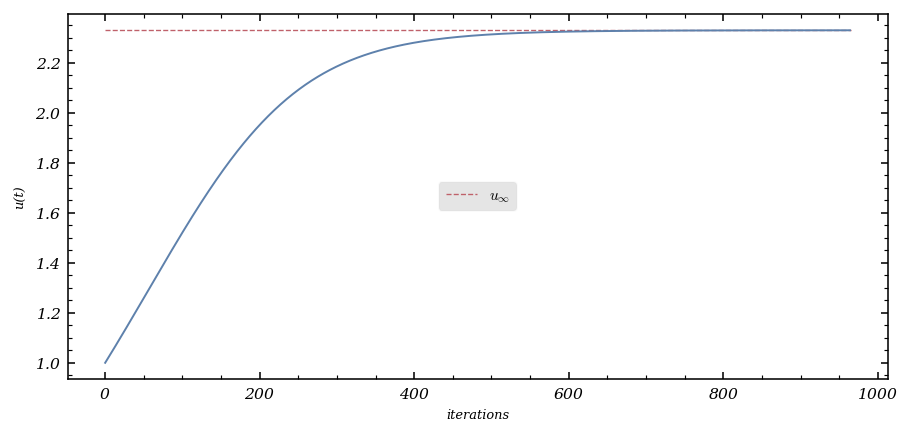

In [4]:
fig,ax = plt.subplots()
color = color_list(2)

ax.hlines(sols[-1], 0, len(sols),linestyles='--', lw = .7, color= color[1], label = '$u_\infty$')
ax.plot(sols, lw = 1, color = color[0])
ax.legend(loc = 'center')
ax.set_xlabel('iterations')
ax.set_ylabel('u(t)')

The dependence of the steady states with respect to the $\mu$ parameter may be represented by a *bifurcation diagram*, which plots the steady states of the system as a function of the parameter $\mu$ and the initial value $u_0$.

**Question.** Plot the bifurcation diagram of the dynamical system. One can typically probe values of $\mu$ that range from $-10$ to $10$, and for each of these values, probe values of $u_0$ that range from $-5$ to $5$.

In [5]:
mu_array = np.linspace(-10,10, 75)
u0_array = np.linspace(-5,5,75)



In [6]:
results = np.zeros((75,75))
for k, u0 in enumerate(u0_array) : 
    
    for j, mu in enumerate(mu_array) : 
        
        def f(t, x) : return -x ** 3 + 5 * x + mu
        results[k][j] = rk4(f, delta_t, u0, tol = .001)[-1]

Text(0, 0.5, '$u_0$')

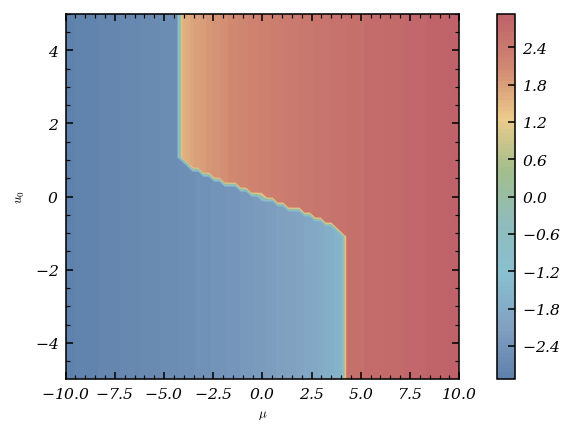

In [7]:
fig, ax = plt.subplots(figsize = (4,3))
mu_array, u0_array = np.meshgrid(mu_array, u0_array)
img = ax.contourf(mu_array, u0_array, results, cmap = cmap1, levels = 100)
plt.colorbar(img)
ax.set_xlabel('$\mu$')
ax.set_ylabel('$u_0$')

**Question.** For a given value of $\mu$, can all the steady states of the considered system be found with the above method?

**Answer.**


## Exercise 2. A complete bifurcation diagram using the Newton-Raphson method.

The time-stepping method being inefficient, another technique is needed to find the unstable steady states of the system. The [Newton-Raphson method](https://en.wikipedia.org/wiki/Newton%27s_method) is a general technique to find the zeros of a function, independently of how stable these zeros are in the context of a dynamical system.

For a function $f$ defined over the set of real numbers, the Newton-Raphson method for the numerical solution of $f(x)=0$ consists in computing the terms of a sequence $(x^{(k)})_{k\in\mathbb{N}}$, defined by the recurrence relation
$$
\forall k\in\mathbb{N},\ x^{(k+1)}=x^{(k)}-\frac{f(x^{(k)})}{f'(x^{(k)})},
$$
starting from a chosen value $x^{(0)}$. In general, this method is not guaranteed to converge to a zero of $f$. When it does, the convergence may necessitate that the starting value $x^{(0)}$ lies in a neighbourhood of a zero (one says that the method is <i>locally convergent</i>).

The choice of the starting guess $x^{(0)}$ being determinant to the limit value of the computed sequence, one will need to try several initial conditions in oder to find every zero of $f$.

**Question.** Write a function `newton_raphson` implementing the method.

In [8]:
def newton_raphson(f : Callable, f_prime : Callable, x_0 : float | Iterable, tol = 10 ** (-10), max_iter = 1000) -> Iterable: 
    """newton_raphson _summary_

    Parameters
    ----------
    f : Callable
        _description_
    f_prime : Callable
        _description_
    x_0 : float | Iterable
        _description_
    tol : _type_, optional
        _description_, by default 10**(-10)
    max_iter : int, optional
        _description_, by default 1000

    Returns
    -------
    Iterable
        _description_
    """    
        
    x = [x_0]
    i = 0 
    while (np.abs(f(x[i])) >= tol) and i <= max_iter: 
        
        x.append(x[i] - f(x[i]) / f_prime(x[i]))
        i += 1
    if i >= max_iter : return np.array([np.infty])
    
    return np.array(x)

def f_prime(x) : return - 3 * x ** 2 + 5 

**Question.** The convergence of the Newton-Raphson method to a zero of $f_\mu$ can be illustrated by plotting the terms of the sequence of absolute residuals $\left(|f_\mu\left(x_n\right)|\right)_{n\in\mathbb{N}}$ for given values of $x_0$ and $\mu$. Is the quadratic convergence of the method always observed?

**Answer.**

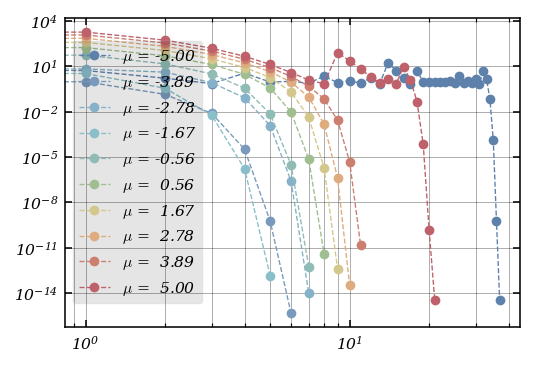

In [9]:
x_0 = 1.2

mu_array = np.linspace(-5,5, 10)
fig, ax = plt.subplots(figsize = (3.7,2.5))
color = color_list(len(mu_array))

for i, mu in enumerate(mu_array):
     
    def f(x) : return -x ** 3 + 5 * x + mu

    ax.loglog(np.abs(f(newton_raphson(f, f_prime,x_0))), linestyle = 'dashed',color = color[i], marker = 'o' ,markersize = 4,lw = .7, label = f'$\mu$ = {mu : .2f}')

ax.legend(loc = 'center left', fontsize = 8)
ax.grid(which = 'both', alpha = .4)





The quadratic convegence is not always observed eg : mu in the range(-10,10)

**Question.** Construct a bifurcation diagram for the dynamical system defined by the Newton-Raphson iteration applied to $f_\mu$.

In [10]:
from tqdm import tqdm

In [11]:
mu_array = np.linspace(-10,10, 75)
u0_array = np.linspace(-5,5,75)

In [12]:
results = np.zeros((75,75))

for k, u0 in enumerate(tqdm(u0_array)) : 
    
    for j, mu in enumerate(mu_array) : 
        
        def f(x) : return -x ** 3 + 5 * x + mu
        results[k][j] = newton_raphson(f, f_prime, u0, tol = 10 ** (-10))[-1]

 25%|██▌       | 19/75 [00:00<00:00, 184.50it/s]

100%|██████████| 75/75 [00:00<00:00, 166.38it/s]


Text(0, 0.5, '$u_0$')

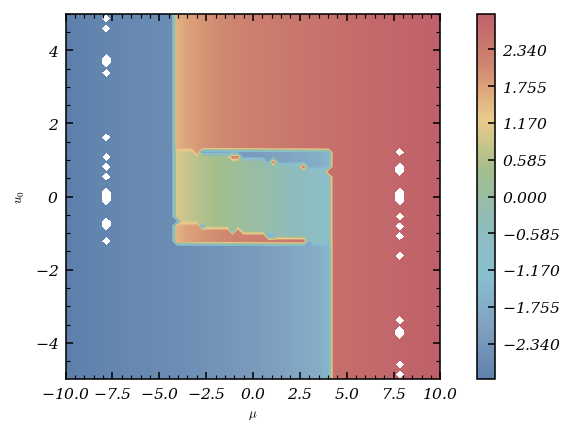

In [13]:
fig, ax = plt.subplots(figsize = (4,3))
mu_array, u0_array = np.meshgrid(mu_array, u0_array)
img = ax.contourf(mu_array, u0_array, results, cmap = cmap1, levels = 500)
plt.colorbar(img)
ax.set_xlabel('$\mu$')
ax.set_ylabel('$u_0$')

## Exercise 3. An application to linear stability analysis.

In the theory of differential equations and dynamical systems, a particular stationary solution to a nonlinear system is called <i>linearly unstable</i> if the linearisation of the equation at this solution has the form $(\delta u)'=A(\delta u)$, where $\delta u$ is the perturbation to the steady state and $A$ is a linear operator whose spectrum contains eigenvalues with positive real part. If all the eigenvalues have negative real part, then the solution is called <i>linearly stable</i>.

In this exercise, we are interested in computing the linear stability diagram of a system by "brute force", using a grid of the parameter space of the system, obtaining the associated stationary states by a technique used in the previous exercises and finally computing the eigenvalues of the matrix $A$.

We consider a very simple model used in biological circuit design for the process of the production and action of a repressor, that is a protein that negatively autoregulates its own production by binding to the promoter region of its own gene, which prevents the production of messenger ribonucleic acid (mRNA). Repressor proteins are essential for the regulation of gene expression in cells.

This model amounts to the following system of dimensionless ordinary differential equations, accounting for the transcription and translation steps in the protein production:
$$
\begin{align*}
m'(t)&=\frac{\beta}{1+(p(t))^n}-m(t),\\
r'(t)&=\kappa(m(t)-r(t)),\\
p'(t)&=\gamma(r(t)-p(t)),
\end{align*}
$$
complemented by initial conditions. Here, $m$, $r$ and $p$ are the respective concentrations of the mRNA, of an intermediate to the functioning protein and of the protein, and $\beta$, $n$, $\kappa$ and $\gamma$ are dimensionless positive parameters.

**Question.** Show that there is a unique stationary solution $(\bar{m},\bar{r},\bar{p})$ to this system, given by $\bar{m}=\bar{r}=\bar{p}$ with $\bar{m}$ satisfying
$$
\bar{m}(1+\bar{m}^n)=\beta.
$$

This leads to the following equation  : 

$$m'(t) = r'(t) = p'(t) = 0$$

$$
\begin{cases}
\bar{p}(t)= \bar{r}(t),\\
\bar{m}(t) = \bar{r}(t), \\
\bar{m}(1+\bar{m}^n)=\beta.
\end{cases}
$$

Hence the solution is unique

**Answer.**

The linearisation of the system at this steady state leads to the following differentiel system for the perturbations $\delta m=m-\bar{m}$, $\delta r=r-\bar{r}$ and $\delta p=p-\bar{p}$ of the form
$$
\begin{pmatrix}\delta m\\\delta r\\\delta p\end{pmatrix}'=\begin{pmatrix}-1&0&-\eta\\\kappa&-\kappa&0\\0&\gamma&-\gamma\end{pmatrix}\begin{pmatrix}\delta m\\\delta r\\\delta p\end{pmatrix},
$$
where $\eta=\dfrac{\beta n(\bar{m})^{n-1}}{(1+(\bar{m}^n))^2}=\dfrac{n(\bar{m})^n}{1+(\bar{m})^n}$.

The characteristic polynomial of the matrix $A$ in this system is
$$
\chi_A(X)=X^3+(1+\kappa+\gamma)X^2+(\kappa(1+\gamma)+\gamma)X+(1+\eta)\kappa\gamma.
$$
According to the <a href="https://en.wikipedia.org/wiki/Descartes%27_rule_of_signs">Descartes rule of signs</a>, this polynomial has no positive real roots and either one or three negative real roots. In the case where there is one negative root, the other are complex conjugate. If these complex conjugate roots have a positive real part, the system will present an oscillatory instability.

We now aim at determining the linear stability diagram of the system in the $\beta$-$\gamma$ space.

**Question.** Write a program computing the linear stability diagram of the system. The values of the parameter $\beta$ will vary between $1$ and $10^4$, those of the parameter $\gamma$ will vary between $10^{-2}$ and $10^{2}$, with $\kappa=1$ (one assumes that conversion to intermediate dominates mRNA loss) and $n=10$ (one assumes high ultrasensitivity of repression). The grid will be built using the `logspace` function  (see the [documentation](https://numpy.org/doc/stable/reference/generated/numpy.logspace.html)) from <tt>numpy</tt>. The `linalg.eigvals` function (see the [documentation](https://numpy.org/doc/stable/reference/generated/numpy.linalg.eigvals.html)) from <tt>numpy</tt> may be used for the computation of the eigenvalues.

In [14]:
def linearized_system(kappa : float, eta : float, gamma : float) -> Iterable : 
    """linearized_system _summary_

    Parameters
    ----------
    kappa : float
        _description_
    eta : float
        _description_
    gamma : float
        _description_

    Returns
    -------
    Iterable
        _description_
    """    
    A = np.array([[- 1 ,   0  , - eta], 
                  [kappa, -kappa, 0],
                  [0, gamma, -gamma]])
    
    return A

In [15]:
Beta = np.logspace(0,4,200) ; n = 10 ; kappa = 1 ; Gamma = np.logspace(-2,2,200)

In [16]:
results = np.zeros((200,200))
for k, beta in enumerate(tqdm(Beta, desc= 'Computing mARN concentration steady state and eighenvalues of the system')) : 
    
    for j, gamma in enumerate(Gamma) : 
        
        
        def equation_m(x) : return x * (x ** n  + 1) - beta
        def equation_m_prime(x) : return 1 + (n+1) * x ** n 
        
        m_ = newton_raphson(equation_m, equation_m_prime, 0, tol = 10 ** (-8))[-1]
        eta = (n * m_ ** n) / (1 + m_ ** n )
        
        A = linearized_system(kappa, eta, gamma)
        eigh_vals = np.linalg.eigvals(A)
        
        if (np.real(eigh_vals) <= 0).all() :
            results[k][j] = 1
        
        else : results[k][j] = 0

Computing mARN concentration steady state and eighenvalues of the system: 100%|██████████| 200/200 [00:07<00:00, 27.07it/s]


**Question.** Plot the obtained diagram using the `imshow` function (see the [documentation](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html)) from <tt>matplotlib</tt>.

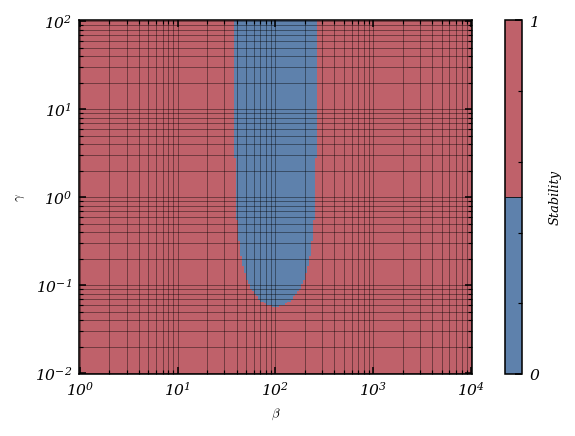

In [17]:
fig, ax = plt.subplots(figsize = (4,3))
Beta_plot, Gamma_plot = np.meshgrid(Beta, Gamma)
img = ax.pcolormesh(Beta_plot, Gamma_plot, results, cmap = cmap1.resampled(2))
ax.set_xlabel(r'$\beta$')
ax.set_ylabel(r'$\gamma$')

ax.set_xscale('log')
ax.set_yscale('log')
plt.colorbar(img, label = 'Stability', drawedges = True, ticks = [0,1   ])

ax.grid(which = 'both', alpha = .5)

## Exercise 4. Basins of attraction of the Newton-Raphson method.

In the field of dynamical systems, an [*attractor*](https://en.wikipedia.org/wiki/Attractor) is a set of states toward which a system tends to evolve, for a wide variety of starting conditions of the system. An attractor's *basin of attraction* is the region of the phase space, over which iterations are defined, such that any point (any initial condition) in that region will asymptotically be iterated into the attractor. 

In this exercise, we are interested in the numerical determination of the basins of attraction of the dynamical system defined by the Newton-Raphson iteration applied to complex polynomial function
$$
f(z)=z^3-1.
$$
The zeros of these function are $1$, $e^{\frac{2i\pi}{3}}$ and $e^{-\frac{2i\pi}{3}}$ and called the cube roots of unity. Still, one can try to approximate these roots with using the Newton-Raphson method and initial approximation points chosen on a regular grid in the complex plane to show that the method can be very sensitive to its choice of start point.

**Question.** Taking initial approximations on a dense enough grid of the set $\left[-\frac{3}{2},\frac{3}{2}\right]\times\left[-i\frac{3}{2},i\frac{3}{2}\right]$ in the complex plane, use the Newton-Raphson method to determine the zeros of $f$. A maximum number of iterations will be set in case of non-convergence of the method.

In [18]:
def newton_raphson_vectorize(f : Callable, f_prime : Callable, map_0 : Iterable, tol = 10 ** (-10), max_iter = 300) : 
    """newton_raphson_vectorize _summary_

    Parameters
    ----------
    f : Callable
        _description_
    f_prime : Callable
        _description_
    map_0 : Iterable
        _description_
    tol : _type_, optional
        _description_, by default 10**(-10)
    max_iter : int, optional
        _description_, by default 300

    Returns
    -------
    _type_
        _description_
    """    
    map = np.copy(map_0)
    i = 0 
    
    while (np.abs(f(map)) >= tol).any() and i <= max_iter: # assume the number of iter is small enough to allow additionnal calculation for valid point
        
        map -= f(map) / f_prime(map)
        i += 1
        
    if i > max_iter : map[np.abs(f(map)) >= tol] = np.infty

    return map

In [19]:
Re = np.linspace(-1.5, 1.5, 2000) ; Im =  np.linspace(-1.5j, 1.5j, 2000)

Re, Im = np.meshgrid(Re, Im)

def f(z) : return z ** 3 + 1

def f_prime(z) : return 3 * z ** 2 

map = newton_raphson_vectorize(f, f_prime, Re + Im)

**Question.** Plot the computed values as a function of the initial approximation. The resulting figure is called a [Newton fractal](https://en.wikipedia.org/wiki/Newton_fractal). Does the Newton-Raphson method always converge in this case?

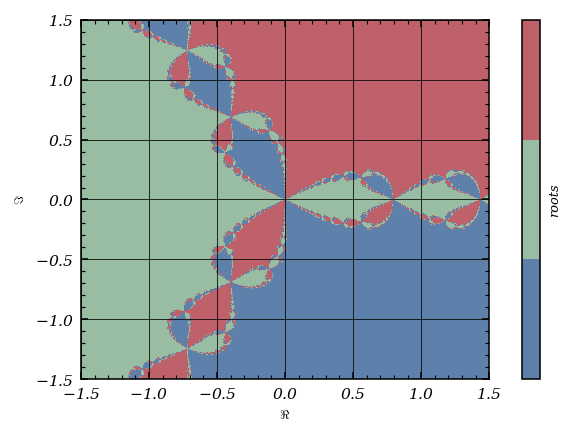

In [20]:
fig, ax = plt.subplots(figsize = (4,3))

img = ax.pcolormesh(Re, Im.imag, map.imag, cmap = cmap1.resampled(3))

plt.colorbar(img, ticks = [], label = 'roots')
ax.set_xlabel('$\Re$')
ax.set_ylabel('$\Im$')
ax.grid()

**Answer.**

For the pedagogical purpose of using the Newton-Raphson method for the numerical solution of a system of non-linear equations, let us now identify $\mathbb{C}$ to $\mathbb{R}^2$ and consider the function $F:\mathbb{R}^2\rightarrow\mathbb{R}^2$ defined as:
$$
F(x,y)=\begin{pmatrix}f_1(x,y)\\f_2(x,y)\end{pmatrix}=\begin{pmatrix}\mathrm{Re}\left(\left(x+iy\right)^3-1\right)\\\mathrm{Im}\left(\left(x+iy\right)^3-1\right)\end{pmatrix},
$$
where $\mathrm{Re}(z)$ and $\mathrm{Im}(z)$ respectively denote the real and imaginary part of a complex number $z$.

For such vector-valued function, the recurrence relation defining the Newton-Raphson method take the form:
$$
\forall k\in\mathbb{N},\ X^{(k+1)}=X^{(k)}-\mathrm{D}F(X^{(k)})^{-1}F(X^{(k)}),
$$
where $(X^{(k)})_{k\in\mathbb{N}}$ is a sequence of column vectors (of dimension two in the present case) and $\mathrm{D}f(X_n)$ is the *Jacobian matrix* of $F$ at $X^{(k)}$, defined by
$$
\forall(i,j)\in\{1,2\}^2,\ \mathrm{D}f(X) = \left(\frac{\partial f_i}{\partial x_j}(X)\right).
$$

**Question.** Obtain the above plot using this alternative formalism. The `linalg.lu_factor` (see the [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.lu_factor.html)) and `linalg.lu_solve` (see the [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.lu_solve.html)) function from <tt>scipy</tt> may be used to factorise the Jacobian matrix at the current point and solve the associated linear system at each iteration.

We have : $\left(x+iy\right)^3-1 = x^3 + 3ix^2y -3y^2x - iy^3 - 1$

This gives us : 

$\mathrm{D}f(X) = 
\begin{pmatrix}
    3x^2 -3 y^2 & -6yx \\
    6yx &-3y^2 + 3x^2
\end{pmatrix}$

and 
$\mathrm{F}(X) = \begin{pmatrix}
    x^3 - 3y^2x - 1 \\
    3x^2y- y^3
\end{pmatrix} $

In [21]:
Re = np.linspace(-1.5, 1.5, 500) ; Im =  np.linspace(-1.5, 1.5, 500)

Re, Im = np.meshgrid(Re, Im)

In [22]:
def F(x,y) : return np.array([x ** 3 - 3 * y ** 2 * x - 1,
                              3 * x ** 2 * y - y ** 3])

def D_F(x,y) : return np.array([[3 * x ** 2 - 3 * y ** 2, - 6 * y * x], 
                                [6 * y * x, 3 * x ** 2 - 3 * y ** 2]])


In [23]:
from scipy import linalg

def newton_raphson_pedagogical(map_0x, map_0y, tol = 10 ** (-10), max_iter = 300) : 
     
    map =  np.empty_like(map_0x, dtype = complex)
    
    n, p = map_0x.shape
    
    for k in tqdm(range(n)) : 
        
        for j in range(p) : 
            
            x = map_0x[k,j] ; y = map_0y[k,j]
            i = 0 
            
            while (np.abs(F(x,y)) >= tol).all() and i <= max_iter :
                
                F_ = F(x,y) ; D_ = D_F(x,y)
                
                x,y  = np.array([x,y]) - linalg.inv(D_) @ F_
                
                i += 1
                
            if i > max_iter : x,y = np.infty, np.infty
            
            map[k,j] = complex(x,y)
            
    return map

In [24]:
map = newton_raphson_pedagogical(Re, Im)

100%|██████████| 500/500 [01:28<00:00,  5.65it/s]


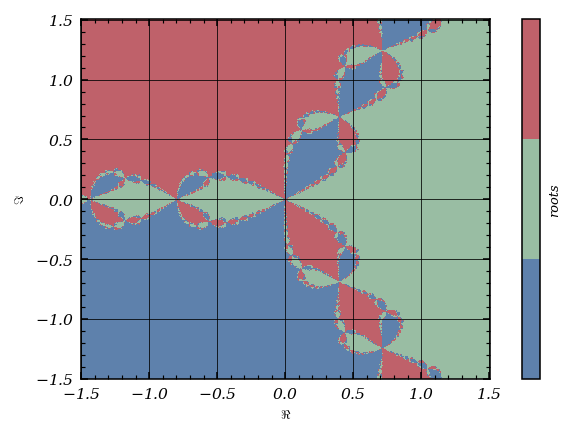

In [25]:
fig, ax = plt.subplots(figsize = (4,3))

img = ax.pcolormesh(Re, Im, map.imag, cmap = cmap1.resampled(3))

plt.colorbar(img, ticks = [], label = 'roots')
ax.set_xlabel('$\Re$')
ax.set_ylabel('$\Im$')
ax.grid()